In [249]:
from Regression import Regression
from Franke import FrankeCentered, FrankeCenteredNoise

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import Lasso
import scipy.stats
import time
from imageio import imread
from tqdm import tqdm, trange

mpl.style.use("seaborn-darkgrid")
mpl.rcParams["image.cmap"] = "gnuplot2"
mpl.rcParams['figure.figsize'] = [6.0, 6.0]
mpl.rcParams["font.size"] = 14

np.random.seed(1942)

# 1 **Set up**

In [272]:
x, y = np.linspace(-0.5, 0.5, 101), np.linspace(-0.5, 0.5, 101)
reg = Regression()
reg.generate_generic_data(x, y, FrankeCenteredNoise)

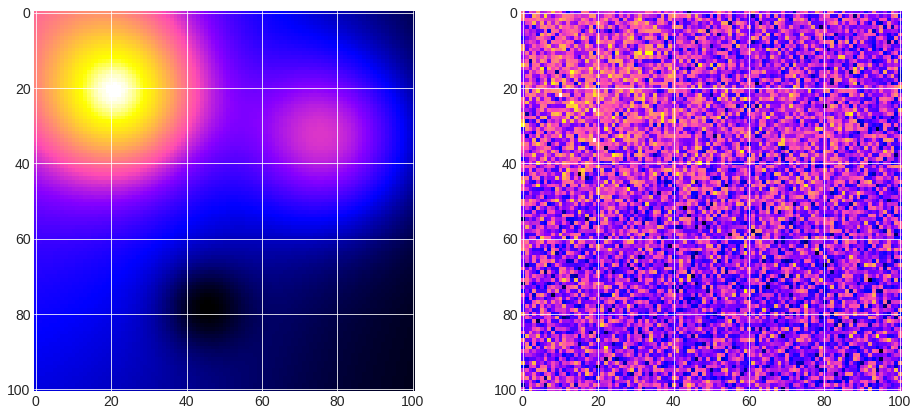

In [273]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
franke_noiseless = FrankeCentered(reg.x_mesh, reg.y_mesh)
ax1.imshow(franke_noiseless);
ax2.imshow(reg.f);

# 2. **OLS**

fitting 

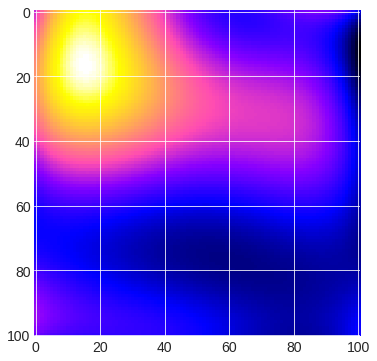

In [274]:
beta_ols = reg.solveCoefficients(poly_order=5, solver="OLS")
data_pred_ols = reg.apply_model(beta_ols, reg.x_mesh, reg.y_mesh)

plt.imshow(data_pred_ols);

**Error**

In [288]:
mse = MSE(reg.f, data_pred_ols)
rmse = np.sqrt(mse)
rrmse = rmse/np.mean(reg.f)
r2 = r2_score(reg.f, data_pred_ols)
print("metrics vs noisy franke (data trained on): ", mse, rmse, rrmse, r2)
"""
mse = MSE(franke_noiseless, data_pred_ols)
rmse = np.sqrt(mse)
rrmse = rmse/np.mean(reg.f)
r2 = r2_score(franke_noiseless, data_pred_ols)
print("metrics vs noiseless franke: ", mse, rmse, rrmse, r2)
""";

metrics vs noisy franke (data trained on):  0.9844141040219371 0.9921764480282411 2.4731512918326577 0.04706321536179207


**confidence interval of beta**

array([[-17.31640712,  18.07857642],
       [ -4.62189808,   0.72867137],
       [ -1.46382948,   0.55326123],
       [ 13.93669419,  14.34561279],
       [  0.15909238,   0.64183477],
       [-27.79637707, -27.67402075],
       [ -2.89041561,   2.46015384],
       [  1.13966098,   3.58419546],
       [ -8.4205914 ,  -7.90405407],
       [ -5.56785064,  -5.01439265],
       [ 19.81062864,  19.95137102],
       [  0.82190591,   2.83899661],
       [ -3.66989205,  -3.15335472],
       [  2.27171763,   2.8354699 ],
       [-13.2889248 , -13.14462183],
       [  0.25948712,   0.66840572],
       [ -3.69132842,  -3.13787043],
       [ 12.65301293,  12.79731589],
       [ -9.50454946,  -9.02180707],
       [ 28.42805619,  28.56879857],
       [ -2.38166776,  -2.25931144]])

# 3. **OLS K-FOLDING**

In [320]:
data_pred_Kfolding = reg.solveKFold(K=10, poly_order=5, solver="OLS")

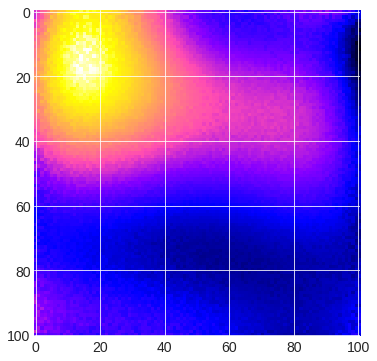

In [313]:
plt.imshow(data_pred_Kfolding)

In [321]:
mse_ols = MSE(reg.f, data_pred_Kfolding)
rmse_ols = np.sqrt(mse_ols)
r2_ols = r2_score(reg.f, data_pred_Kfolding)
print("mse, rmse and r2 score for k-folding with k=10", mse_ols,rmse_ols,r2_ols)

mse, rmse and r2 score for k-folding with k=10 0.9883649568038947 0.9941654574586137 0.04327470844939303


**Solving for different values of K**

In [315]:
data_pred_list = []
for i in trange(5, 50, 2):
    K = i
    data_pred = reg.solveKFold(K=K, poly_order=5, solver="OLS")
    data_pred_list.append(data_pred)


100%|██████████| 23/23 [00:08<00:00,  2.68it/s]


In [316]:
mse_list = []
mse_list_noiseless = []
r2_list = []
r2_list_noiseless = []
for i in range(len(data_pred_list)):
    data_pred = data_pred_list[i]
    mse_list.append(MSE(reg.f, data_pred))
    mse_list_noiseless.append(MSE(franke_noiseless, data_pred))
    r2_list.append(r2_score(reg.f, data_pred))
    r2_list_noiseless.append(r2_score(franke_noiseless, data_pred))

**MSE and R2-plots for different values of K**

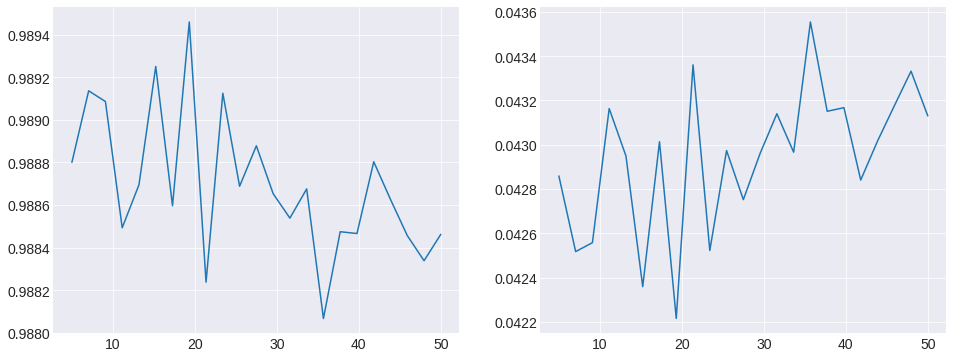

In [283]:
n = len(mse_list)
k = np.linspace(5,50,n)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
ax1.plot(k,mse_list);
ax2.plot(k,r2_list);

**RIDGE**

In [322]:
data_pred_ridge = reg.solveKFold(K=10, poly_order=5, solver="Ridge")

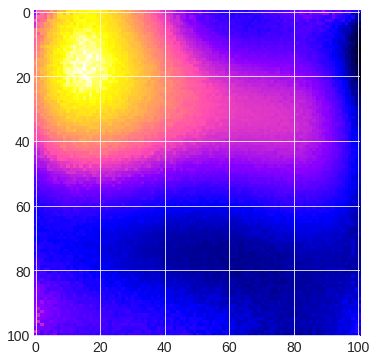

In [323]:
plt.imshow(data_pred_ridge);

In [324]:
mse_list = []
mse_list_noiseless = []
r2_list = []
r2_list_noiseless = []
lamda_list = np.logspace(1, -8, 16)
for i in trange(len(lamda_list)):
    lamda = lamda_list[i]
    data_pred = reg.solveKFold(K=10, poly_order=5, solver="Ridge", lamda=lamda)
    mse_list.append(MSE(reg.f, data_pred))
    mse_list_noiseless.append(MSE(franke_noiseless, data_pred))
    r2_list.append(r2_score(reg.f, data_pred))
    r2_list_noiseless.append(r2_score(franke_noiseless, data_pred))


100%|██████████| 16/16 [00:02<00:00,  7.41it/s]


**Plots showing how the error behaves for increasing values of Lambda** 

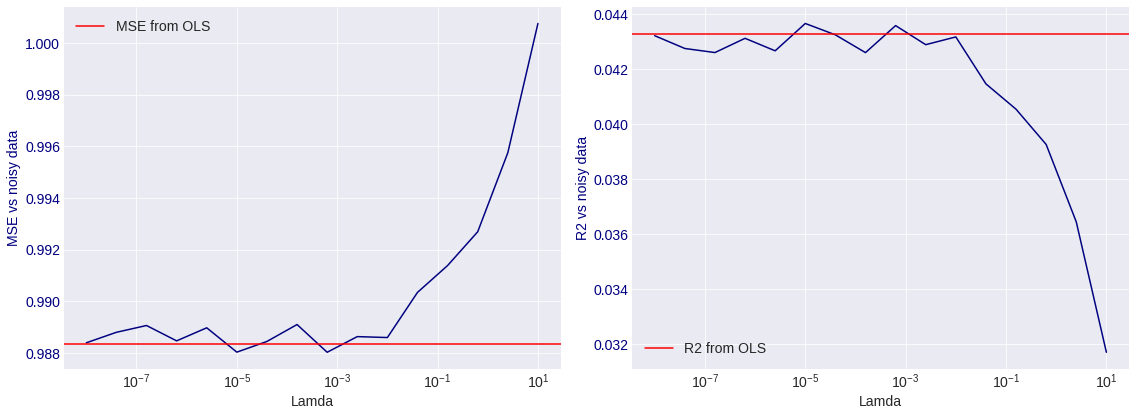

In [325]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
ax1.semilogx(lamda_list, mse_list, c="navy");
ax2.semilogx(lamda_list, r2_list, c="navy");
ax1.axhline(y=mse_ols, xmin=0.0, xmax=1.0, color='r',label="MSE from OLS")
ax2.axhline(y=r2_ols, xmin=0.0, xmax=1.0, color='r', label="R2 from OLS")
ax1.legend()
ax2.legend()
ax1.set_xlabel("Lamda")
ax1.set_ylabel("MSE vs noisy data", color="navy");
ax1.tick_params(axis='y', labelcolor="navy")
ax2.set_xlabel("Lamda")
ax2.set_ylabel("R2 vs noisy data", color="navy");
ax2.tick_params(axis='y', labelcolor="navy")
fig.tight_layout()

In [326]:
reg.solveCoefficients(solver="Ridge")

array([-1.94312024e-02, -1.88078197e+00, -4.40495290e-01,  1.36256111e+01,
        3.87351469e-01, -2.66501588e+01, -2.09303853e-01,  2.28530688e+00,
       -7.86819056e+00, -5.11877015e+00,  1.91413987e+01,  1.77064095e+00,
       -3.28172180e+00,  2.47052556e+00, -1.27303195e+01,  4.49910145e-01,
       -3.30333547e+00,  1.22545409e+01, -8.96061558e+00,  2.74464797e+01,
       -2.23091420e+00])

**LASSO**

In [330]:
data_pred_lasso = reg.solveKFold(K=10,poly_order=5,solver='Lasso')

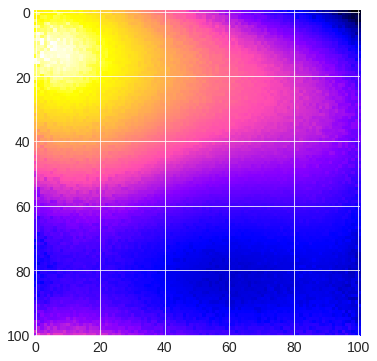

In [331]:
plt.imshow(data_pred_lasso)

In [333]:
mse = MSE(reg.f, data_pred_lasso)
rmse = np.sqrt(mse)
r2 = r2_score(reg.f, data_pred_lasso)
print("mse, rmse and r2 score for lasso,", mse, rmse, r2)

mse, rmse and r2 score for lasso, 0.9927246805405301 0.9963556998083215 0.0393167152129288


In [270]:
reg.solveCoefficients(solver="Lasso")

array([-0.00447946, -1.28807822, -0.17496454,  4.04086565, -0.69736925,
        0.        , -0.53216836,  0.89887324, -0.99772984, -0.        ,
        0.        ,  0.98116475,  0.37664714,  0.        ,  0.        ,
        0.92484149, -0.56843457,  0.        , -4.26500949,  0.        ,
        0.        ])

In [ ]:
data_pred_lasso_comparison = reg.solveKFold(K=10, poly_order=5, solver='Lasso'

In [338]:
mse_list = []
mse_list_noiseless = []
r2_list = []
r2_list_noiseless = []
lamda_list = np.logspace(-2, -8, 16)
for i in trange(len(lamda_list)):
    lamda = lamda_list[i]
    data_pred = reg.solveKFold(K=10, poly_order=5, solver="Lasso", lamda=lamda)
    mse_list.append(MSE(reg.f, data_pred))
    mse_list_noiseless.append(MSE(franke_noiseless, data_pred))
    r2_list.append(r2_score(reg.f, data_pred))
    r2_list_noiseless.append(r2_score(franke_noiseless, data_pred))


 56%|█████▋    | 9/16 [00:11<00:17,  2.44s/it]/home/julie/.local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1104656270345004, tolerance: 0.915261345587952
  positive)
/home/julie/.local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2785769633537711, tolerance: 0.9201985470889417
  positive)
/home/julie/.local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0637538176015369, tolerance: 0.9142060681911919
  positive)
/home/julie/.local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge

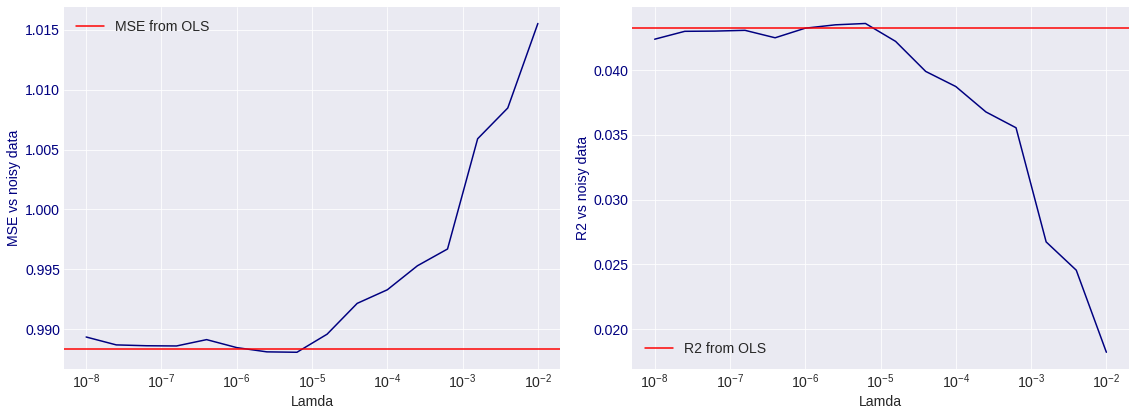

In [339]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
ax1.semilogx(lamda_list, mse_list, c="navy");
ax2.semilogx(lamda_list, r2_list, c="navy");
ax1.axhline(y=mse_ols, xmin=0.0, xmax=1.0, color='r',label="MSE from OLS")
ax2.axhline(y=r2_ols, xmin=0.0, xmax=1.0, color='r', label="R2 from OLS")
ax1.legend()
ax2.legend()
ax1.set_xlabel("Lamda")
ax1.set_ylabel("MSE vs noisy data", color="navy");
ax1.tick_params(axis='y', labelcolor="navy")
ax2.set_xlabel("Lamda")
ax2.set_ylabel("R2 vs noisy data", color="navy");
ax2.tick_params(axis='y', labelcolor="navy")
fig.tight_layout()